### Multi step model (simple encoder-decoder)

In this notebook, we demonstrate how to:
- prepare time series data for training a RNN forecasting model
- get data in the required shape for the keras API
- implement a RNN model in keras to predict the next 3 steps ahead (time *t+1* to *t+3*) in the time series. This model uses a simple encoder decoder approach in which the final hidden state of the encoder is replicated across each time step of the decoder. 
- enable early stopping to reduce the likelihood of model overfitting
- evaluate the model on a test dataset

The data in this example is taken from the GEFCom2014 forecasting competition<sup>1</sup>. It consists of 3 years of hourly electricity load and temperature values between 2012 and 2014. The task is to forecast future values of electricity load.

<sup>1</sup>Tao Hong, Pierre Pinson, Shu Fan, Hamidreza Zareipour, Alberto Troccoli and Rob J. Hyndman, "Probabilistic energy forecasting: Global Energy Forecasting Competition 2014 and beyond", International Journal of Forecasting, vol.32, no.3, pp 896-913, July-September, 2016.

In [88]:
import os
import warnings
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime as dt
from collections import UserDict
from IPython.display import Image
%matplotlib inline

from common.utils import load_data, mape, TimeSeriesTensor, create_evaluation_df

pd.options.display.float_format = '{:,.20f}'.format
np.set_printoptions(precision=20)
warnings.filterwarnings("ignore")

In [89]:
Paras = {
    'M0':['M0', 'e','Del_n' , 'sqrt_A'],
    'e':['OMEGA','i0','omega','I_dot','Cus','Crs','e' , 'M0'],
    'sqrt_A':['Cuc','Crc','Del_n','Crs','sqrt_A','OMEGA_dot','Cus'],
    'OMEGA':['OMEGA','e','i0','omega'],
    'i0':['e','i0','omega','OMEGA' ,'I_dot'],
    'omega':['omega','e','OMEGA','i0'],
    'I_dot':['I_dot','e','Crs','Cuc'],
    'Cic':['M0','Cic'],
    'Cis':['Cis'],
    'OMEGA_dot':['OMEGA_dot','sqrt_A','Crc','Del_n','Cus' , 'omega' ],
    'Cuc':['Cuc','e','sqrt_A','I_dot','Crs'],
    'Cus':['Cus','sqrt_A','OMEGA_dot','Crc','Del_n','Cus'],
    'Crc':['Crc','sqrt_A','OMEGA_dot','Cus','Del_n'],
    'Crs':['Crs','e','sqrt_A','I_dot','Cuc'],
    'Del_n':['Crc','sqrt_A','OMEGA_dot','Cus','Del_n'],
    'Codes' : ['Codes']    
}


In [90]:
var_name = 'Cis'
sat_var  = 2

In [91]:
df = pd.read_csv("hourinterpol_21.csv" , parse_dates = True)
a = pd.to_datetime(df['Epoch_Time_of_Clock'])
print(type(a[0]))
#df = df.drop(['Unnamed: 0', 'Unnamed: 0.1' ,'sqrt_A'  ,'PRN','SV_Clock_Bias', 'SV_Clock_Drift', 'SV_Clock_Drift_Rate', 'IODE', 'Crs',
#       'Del_n', 'Cuc','Cus','Toe', 'Cic', 
#       'Cis', 'Crc', 'M0', 'OMEGA_dot', 'I_dot', 'Codes', 'GPS_week',
#       'L2_P_Data_flag', 'SV_accuracy', 'SV_health', 'Tgd', 'IODC', 'T_Tx',
#       'Fit_Interval' ,'Epoch_Time_of_Clock' ],axis =1 )
df = df.loc[:,Paras[var_name]]
#df.head()
#df = df.set_index(['Epoch_Time_of_Clock'])
df = df.set_index(a)
df.head()

<class 'pandas._libs.tslib.Timestamp'>


,Cis
Epoch_Time_of_Clock,
2017-11-02 00:00:00,0.00000076779053878500
2017-11-02 01:00:00,0.00000057093921911800
2017-11-02 02:00:00,0.00000035043437778500
2017-11-02 03:00:00,0.00000010818876481900
2017-11-02 04:00:00,-0.00000015100000000000


In [92]:
test = df.iloc[265:408,:]

In [93]:
df.head(7)

,Cis
Epoch_Time_of_Clock,
2017-11-02 00:00:00,0.00000076779053878500
2017-11-02 01:00:00,0.00000057093921911800
2017-11-02 02:00:00,0.00000035043437778500
2017-11-02 03:00:00,0.00000010818876481900
2017-11-02 04:00:00,-0.00000015100000000000
2017-11-02 05:00:00,-0.00000035578135957500
2017-11-02 06:00:00,-0.00000037545560338400


# Enter number of entries per day

In [94]:
'''entry = 6
print(df.shape[0])
no_of_entries = df.shape[0]//entry
valid = (no_of_entries * 70)//100
test = (no_of_entries * 85)//100
indexes = df.index
#print(valid , test , indexes)
valid_start_dt = indexes[int(valid)*int(entry)] 
test_start_dt = indexes [int(test)*int(entry)] 
test_start_dt = str(test_start_dt)
valid_start_dt = str(valid_start_dt)
print(test_start_dt,valid_start_dt)
print(type(test_start_dt))'''
valid_start_dt = '2017-11-07 00:00:00'
test_start_dt = '2017-11-11 00:00:00'


Load data into Pandas dataframe

# enter lag and no. of outputs

In [95]:
"""total = len(df)
t = total*70/100
t = round(t)
indexes = df.index
valid_start_dt = str(indexes[t])
t = total*85/100
t = round(t)
test_start_dt = str(indexes[t])
print(valid_start_dt , test_start_dt)
"""
T = 24
HORIZON = 24

Create training set containing only the model features

In [96]:
train = df.copy()[df.index < valid_start_dt][Paras[var_name ]]
train.head()

,Cis
Epoch_Time_of_Clock,
2017-11-02 00:00:00,0.00000076779053878500
2017-11-02 01:00:00,0.00000057093921911800
2017-11-02 02:00:00,0.00000035043437778500
2017-11-02 03:00:00,0.00000010818876481900
2017-11-02 04:00:00,-0.00000015100000000000


In [97]:
train.tail(6)

,Cis
Epoch_Time_of_Clock,
2017-11-06 18:00:00,0.00000088535747434900
2017-11-06 19:00:00,0.00000085757414147200
2017-11-06 20:00:00,0.00000080645811342700
2017-11-06 21:00:00,0.00000073465087673800
2017-11-06 22:00:00,0.00000064479391793000
2017-11-06 23:00:00,0.00000053952872352700


Scale data to be in range (0, 1). This transformation should be calibrated on the training set only. This is to prevent information from the validation or test sets leaking into the training data.

# Enter variable to be predicted

In [98]:
from sklearn.preprocessing import StandardScaler



y_scalar = StandardScaler()
y_scalar.fit(train[[var_name]])

X_scaler = StandardScaler()
train[Paras[var_name]] = X_scaler.fit_transform(train)

In [99]:
import pickle
file_x = open(var_name+'X_scaler2_5D_Cis.pkl','wb')
pickle.dump(X_scaler, file_x)
            
file_y = open(var_name+'y_scalar2_5D_Cis.pkl','wb')
pickle.dump(y_scalar, file_y)

Use the TimeSeriesTensor convenience class to:
1. Shift the values of the time series to create a Pandas dataframe containing all the data for a single training example
2. Discard any samples with missing values
3. Transform this Pandas dataframe into a numpy array of shape (samples, time steps, features) for input into Keras

The class takes the following parameters:

- **dataset**: original time series
- **H**: the forecast horizon
- **tensor_structure**: a dictionary discribing the tensor structure in the form { 'tensor_name' : (range(max_backward_shift, max_forward_shift), [feature, feature, ...] ) }
- **freq**: time series frequency
- **drop_incomplete**: (Boolean) whether to drop incomplete samples

In [100]:
tensor_structure = {'X':(range(-T+1, 1), Paras[var_name])}
train_inputs = TimeSeriesTensor(train, var_name, HORIZON, {'X':(range(-T+1, 1), Paras[var_name])} ,freq = None)

In [101]:
train_inputs.dataframe

tensor                               target                          \
feature                                   y                           
time step                               t+1                     t+2   
Epoch_Time_of_Clock                                                   
2017-11-02 23:00:00  0.47574268254966639580  0.09546776365503095718   
2017-11-03 00:00:00  0.09546776365503095718 -0.32874056473350715679   
2017-11-03 01:00:00 -0.32874056473350715679 -0.79293659535703553409   
2017-11-03 02:00:00 -0.79293659535703553409 -1.28764863836837362143   
2017-11-03 03:00:00 -1.28764863836837362143 -1.67200211129484266337   
2017-11-03 04:00:00 -1.67200211129484266337 -1.68832825721877144431   
2017-11-03 05:00:00 -1.68832825721877144431 -1.40379747318579628512   
2017-11-03 06:00:00 -1.40379747318579628512 -1.20048867957195271039   
2017-11-03 07:00:00 -1.20048867957195271039 -1.12400264488503531801   
2017-11-03 08:00:00 -1.12400264488503531801 -0.88021139163860651067   
2017-11-03 09:00:00 -0.88021139163860651067 -0.41502097813301025431   
2017-11-03 10:00:00 -0.41502097813301025431  0.07425734723560403761   
2017-11-03 11:00:00  0.07425734723560403761  0.48289882455654176141   
2017-11-03 12:00:00  0.48289882455654176141  0.80995982154570345113   
2017-11-03 13:00:00  0.80995982154570345113  1.05885149078869833517   
2017-11-03 14:00:00  1.05885149078869833517  1.23302253280593787643   
2017-11-03 15:00:00  1.23302253280593787643  1.33592164811147084968   
2017-11-03 16:00:00  1.33592164811147084968  1.37099753721722494859   
2017-11-03 17:00:00  1.37099753721722494859  1.34169890063300534244   
2017-11-03 18:00:00  1.34169890063300534244  1.25143545851379656142   
2017-11-03 19:00:00  1.25143545851379656142  1.10377285251871515293   
2017-11-03 20:00:00  1.10377285251871515293  0.90204284201037820967   
2017-11-03 21:00:00  0.90204284201037820967  0.64973310789159377521   
2017-11-03 22:00:00  0.64973310789159377521  0.35029235068065189829   
2017-11-03 23:00:00  0.35029235068065189829  0.00716927089160161301   
2017-11-04 00:00:00  0.00716927089160161301 -0.37618743095514572961   
2017-11-04 01:00:00 -0.37618743095514572961 -0.79632905434638989739   
2017-11-04 02:00:00 -0.79632905434638989739 -1.24446861153720589321   
2017-11-04 03:00:00 -1.24446861153720589321 -1.58903850858491524356   
2017-11-04 04:00:00 -1.58903850858491524356 -1.58950839654209463703   
...                                     ...                     ...   
2017-11-04 18:00:00  1.18454938622639360801  1.09872046029392311794   
2017-11-04 19:00:00  1.09872046029392311794  0.95993621171311849238   
2017-11-04 20:00:00  0.95993621171311849238  0.77154035412001154004   
2017-11-04 21:00:00  0.77154035412001154004  0.53725864406626033798   
2017-11-04 22:00:00  0.53725864406626033798  0.26072132737355757648   
2017-11-04 23:00:00  0.26072132737355757648 -0.05444135013852774430   
2017-11-05 00:00:00 -0.05444135013852774430 -0.40459914264830321162   
2017-11-05 01:00:00 -0.40459914264830321162 -0.78612180433619860409   
2017-11-05 02:00:00 -0.78612180433619860409 -1.19061644003423849902   
2017-11-05 03:00:00 -1.19061644003423849902 -1.50014921957173563705   
2017-11-05 04:00:00 -1.50014921957173563705 -1.49990151153042416965   
2017-11-05 05:00:00 -1.49990151153042416965 -1.26138311143960724081   
2017-11-05 06:00:00 -1.26138311143960724081 -1.13232725618140550594   
2017-11-05 07:00:00 -1.13232725618140550594 -1.13116771290708628683   
2017-11-05 08:00:00 -1.13116771290708628683 -0.94613416342935396930   
2017-11-05 09:00:00 -0.94613416342935396930 -0.52087357194315830888   
2017-11-05 10:00:00 -0.52087357194315830888 -0.06452503103189161093   
2017-11-05 11:00:00 -0.06452503103189161093  0.31225499381060406456   
2017-11-05 12:00:00  0.31225499381060406456  0.60904418233509349800   
2017-11-05 13:00:00  0.60904418233509349800  0.83021300321190860672   
2017-11-05 14:00:00  0.83021300321190860672  0.98013192511138069740   
2017-11-05 15:00:00  0.9

In [102]:
train_inputs['target'].shape

(73, 24)

Construct validation set (keeping T hours from the training set in order to construct initial features)

In [103]:
look_back_dt = dt.datetime.strptime(valid_start_dt, '%Y-%m-%d %H:%M:%S') - dt.timedelta(hours=T-1)
valid = df.copy()[(df.index >=look_back_dt) & (df.index < test_start_dt)][Paras[var_name]]
valid[Paras[var_name]] = X_scaler.transform(valid)
valid_inputs = TimeSeriesTensor(valid, var_name, HORIZON, tensor_structure,freq = None)
valid_inputs.dataframe.head()

tensor                               target                          \
feature                                   y                           
time step                               t+1                     t+2   
Epoch_Time_of_Clock                                                   
2017-11-07 00:00:00 -0.35347281376594080760 -0.64117298502466024690   
2017-11-07 01:00:00 -0.64117298502466024690 -0.93914385394652544203   
2017-11-07 02:00:00 -0.93914385394652544203 -1.23866742912692129330   
2017-11-07 03:00:00 -1.23866742912692129330 -1.45952052366517048831   
2017-11-07 04:00:00 -1.45952052366517048831 -1.45842228370952087246   

tensor                                                               \
feature                                                               
time step                               t+3                     t+4   
Epoch_Time_of_Clock                                                   
2017-11-07 00:00:00 -0.93914385394652544203 -1.23866742912692129330   
2017-11-07 01:00:00 -1.23866742912692129330 -1.45952052366517048831   
2017-11-07 02:00:00 -1.45952052366517048831 -1.45842228370952087246   
2017-11-07 03:00:00 -1.45842228370952087246 -1.28454429199374220438   
2017-11-07 04:00:00 -1.28454429199374220438 -1.17222221358390688017   

tensor                                                               \
feature                                                               
time step                               t+5                     t+6   
Epoch_Time_of_Clock                                                   
2017-11-07 00:00:00 -1.45952052366517048831 -1.45842228370952087246   
2017-11-07 01:00:00 -1.45842228370952087246 -1.28454429199374220438   
2017-11-07 02:00:00 -1.28454429199374220438 -1.17222221358390688017   
2017-11-07 03:00:00 -1.17222221358390688017 -1.12575816603556977391   
2017-11-07 04:00:00 -1.12575816603556977391 -0.92001191178813268579   

tensor                                                               \
feature                                                               
time step                               t+7                     t+8   
Epoch_Time_of_Clock                                                   
2017-11-07 00:00:00 -1.28454429199374220438 -1.17222221358390688017   
2017-11-07 01:00:00 -1.17222221358390688017 -1.12575816603556977391   
2017-11-07 02:00:00 -1.12575816603556977391 -0.92001191178813268579   
2017-11-07 03:00:00 -0.92001191178813268579 -0.52861014432567132726   
2017-11-07 04:00:00 -0.52861014432567132726 -0.13018104213790093748   

tensor                                                               \
feature                                                               
time step                               t+9                    t+10   
Epoch_Time_of_Clock                                                   
2017-11-07 00:00:00 -1.12575816603556977391 -0.92001191178813268579   
2017-11-07 01:00:00 -0.92001191178813268579 -0.52861014432567132726   
2017-11-07 02:00:00 -0.52861014432567132726 -0.13018104213790093748   
2017-11-07 03:00:00 -0.13018104213790093748  0.18269483035097058843   
2017-11-07 04:00:00  0.18269483035097058843  0.41257748067634314459   

tensor                        ...                                X  \
feature                       ...                              Cis   
time step                     ...                              t-9   
Epoch_Time_of_Clock           ...                                    
2017-11-07 00:00:00           ...           0.72604588594993590966   
2017-11-07 01:00:00           ...           0.84920135166880339472   
2017-11-07 02:00:00           ...           0.90605909057124245365   
2017-11-07 03:00:00           ...           0.90222180557340803109   
2017-11-07 04:00:00           ...           0.84329219958933643309   

tensor                                                             \
feature                                                             
time step                      

## Implement the RNN

We will implement a RNN forecasting model with the following structure:

In [104]:
#Image('./images/simple_encoder_decoder.png')

In [105]:
from keras.models import Model, Sequential
from keras.layers import LSTM, Dense, RepeatVector, TimeDistributed, Flatten
from keras.callbacks import EarlyStopping ,ModelCheckpoint

In [106]:
LATENT_DIM = 64
BATCH_SIZE = 32
EPOCHS = 1000

In [107]:
model = Sequential()
model.add(LSTM(LATENT_DIM, input_shape=(T,1 )))
model.add(RepeatVector(HORIZON))
model.add(LSTM(LATENT_DIM, return_sequences=True))
model.add(TimeDistributed(Dense(1)))
model.add(Flatten())

In [108]:
model.compile(optimizer='RMSprop', loss='mse')

In [109]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_7 (LSTM)                (None, 64)                16896     
_________________________________________________________________
repeat_vector_4 (RepeatVecto (None, 24, 64)            0         
_________________________________________________________________
lstm_8 (LSTM)                (None, 24, 64)            33024     
_________________________________________________________________
time_distributed_4 (TimeDist (None, 24, 1)             65        
_________________________________________________________________
flatten_4 (Flatten)          (None, 24)                0         
Total params: 49,985
Trainable params: 49,985
Non-trainable params: 0
_________________________________________________________________


In [110]:
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=500)

In [111]:
best_val = ModelCheckpoint(str(sat_var) +'_' +  var_name + '_{epoch:02d}.h5', save_best_only=True, mode='min', period=1)

In [112]:
history = model.fit(train_inputs['X'],
          train_inputs['target'],
          batch_size=BATCH_SIZE,
          epochs=EPOCHS,
          validation_data=(valid_inputs['X'], valid_inputs['target']),
          callbacks=[earlystop ,best_val],
          verbose=1 , shuffle = False)

Train on 73 samples, validate on 72 samples
Epoch 1/1000
73/73 [==============================] - 2s 21ms/step - loss: 0.9144 - val_loss: 0.6605
Epoch 2/1000
73/73 [==============================] - 0s 2ms/step - loss: 0.8730 - val_loss: 0.4973
Epoch 3/1000
73/73 [==============================] - 0s 3ms/step - loss: 0.7929 - val_loss: 0.5256
Epoch 4/1000
73/73 [==============================] - 0s 3ms/step - loss: 0.6852 - val_loss: 0.5311
Epoch 5/1000
73/73 [==============================] - 0s 3ms/step - loss: 0.6373 - val_loss: 0.4406
Epoch 6/1000
73/73 [==============================] - 0s 3ms/step - loss: 0.6251 - val_loss: 0.5672
Epoch 7/1000
73/73 [==============================] - 0s 3ms/step - loss: 0.5373 - val_loss: 0.5625
Epoch 8/1000
73/73 [==============================] - 0s 3ms/step - loss: 0.5262 - val_loss: 0.6384
Epoch 9/1000
73/73 [==============================] - 0s 3ms/step - loss: 0.4762 - val_loss: 0.5284
Epoch 10/1000
73/73 [==============================] - 

73/73 [==============================] - 0s 2ms/step - loss: 0.0712 - val_loss: 0.4384
Epoch 82/1000
73/73 [==============================] - 0s 1ms/step - loss: 0.0524 - val_loss: 0.4061
Epoch 83/1000
73/73 [==============================] - 0s 1ms/step - loss: 0.0706 - val_loss: 0.4349
Epoch 84/1000
73/73 [==============================] - 0s 2ms/step - loss: 0.0518 - val_loss: 0.4020
Epoch 85/1000
73/73 [==============================] - 0s 1ms/step - loss: 0.0700 - val_loss: 0.4317
Epoch 86/1000
73/73 [==============================] - 0s 3ms/step - loss: 0.0513 - val_loss: 0.3980
Epoch 87/1000
73/73 [==============================] - 0s 3ms/step - loss: 0.0695 - val_loss: 0.4285
Epoch 88/1000
73/73 [==============================] - 0s 3ms/step - loss: 0.0507 - val_loss: 0.3942
Epoch 89/1000
73/73 [==============================] - 0s 2ms/step - loss: 0.0688 - val_loss: 0.4253
Epoch 90/1000
73/73 [==============================] - 0s 2ms/step - loss: 0.0501 - val_loss: 0.3905
Epoc

73/73 [==============================] - 0s 1ms/step - loss: 0.0522 - val_loss: 0.3080
Epoch 162/1000
73/73 [==============================] - 0s 1ms/step - loss: 0.0363 - val_loss: 0.2858
Epoch 163/1000
73/73 [==============================] - 0s 1ms/step - loss: 0.0504 - val_loss: 0.3039
Epoch 164/1000
73/73 [==============================] - 0s 1ms/step - loss: 0.0351 - val_loss: 0.2825
Epoch 165/1000
73/73 [==============================] - 0s 1ms/step - loss: 0.0487 - val_loss: 0.3006
Epoch 166/1000
73/73 [==============================] - 0s 1ms/step - loss: 0.0342 - val_loss: 0.2798
Epoch 167/1000
73/73 [==============================] - 0s 1ms/step - loss: 0.0468 - val_loss: 0.2983
Epoch 168/1000
73/73 [==============================] - 0s 2ms/step - loss: 0.0335 - val_loss: 0.2770
Epoch 169/1000
73/73 [==============================] - 0s 1ms/step - loss: 0.0463 - val_loss: 0.2957
Epoch 170/1000
73/73 [==============================] - 0s 1ms/step - loss: 0.0331 - val_loss: 0.

73/73 [==============================] - 0s 1ms/step - loss: 0.0613 - val_loss: 0.2030
Epoch 242/1000
73/73 [==============================] - 0s 1ms/step - loss: 0.0342 - val_loss: 0.2078
Epoch 243/1000
73/73 [==============================] - 0s 1ms/step - loss: 0.0411 - val_loss: 0.1935
Epoch 244/1000
73/73 [==============================] - 0s 1ms/step - loss: 0.0229 - val_loss: 0.1980
Epoch 245/1000
73/73 [==============================] - 0s 1ms/step - loss: 0.0246 - val_loss: 0.1883
Epoch 246/1000
73/73 [==============================] - 0s 1ms/step - loss: 0.0223 - val_loss: 0.1957
Epoch 247/1000
73/73 [==============================] - 0s 1ms/step - loss: 0.0323 - val_loss: 0.1965
Epoch 248/1000
73/73 [==============================] - 0s 3ms/step - loss: 0.0308 - val_loss: 0.1975
Epoch 249/1000
73/73 [==============================] - 0s 2ms/step - loss: 0.0400 - val_loss: 0.1961
Epoch 250/1000
73/73 [==============================] - 0s 2ms/step - loss: 0.0282 - val_loss: 0.

73/73 [==============================] - 0s 1ms/step - loss: 0.0268 - val_loss: 0.1790
Epoch 322/1000
73/73 [==============================] - 0s 1ms/step - loss: 0.0390 - val_loss: 0.2089
Epoch 323/1000
73/73 [==============================] - 0s 1ms/step - loss: 0.0305 - val_loss: 0.1794
Epoch 324/1000
73/73 [==============================] - 0s 2ms/step - loss: 0.0235 - val_loss: 0.1751
Epoch 325/1000
73/73 [==============================] - 0s 3ms/step - loss: 0.0328 - val_loss: 0.1679
Epoch 326/1000
73/73 [==============================] - 0s 2ms/step - loss: 0.0229 - val_loss: 0.1797
Epoch 327/1000
73/73 [==============================] - 0s 2ms/step - loss: 0.0323 - val_loss: 0.1742
Epoch 328/1000
73/73 [==============================] - 0s 2ms/step - loss: 0.0199 - val_loss: 0.1773
Epoch 329/1000
73/73 [==============================] - 0s 2ms/step - loss: 0.0204 - val_loss: 0.1654
Epoch 330/1000
73/73 [==============================] - 0s 2ms/step - loss: 0.0197 - val_loss: 0.

73/73 [==============================] - 0s 1ms/step - loss: 0.0237 - val_loss: 0.1845
Epoch 402/1000
73/73 [==============================] - 0s 1ms/step - loss: 0.0213 - val_loss: 0.2426
Epoch 403/1000
73/73 [==============================] - 0s 3ms/step - loss: 0.0217 - val_loss: 0.1969
Epoch 404/1000
73/73 [==============================] - 0s 1ms/step - loss: 0.0272 - val_loss: 0.2540
Epoch 405/1000
73/73 [==============================] - 0s 1ms/step - loss: 0.0232 - val_loss: 0.2143
Epoch 406/1000
73/73 [==============================] - 0s 1ms/step - loss: 0.0178 - val_loss: 0.2556
Epoch 407/1000
73/73 [==============================] - 0s 1ms/step - loss: 0.0162 - val_loss: 0.1971
Epoch 408/1000
73/73 [==============================] - 0s 1ms/step - loss: 0.0227 - val_loss: 0.2194
Epoch 409/1000
73/73 [==============================] - 0s 1ms/step - loss: 0.0428 - val_loss: 0.1770
Epoch 410/1000
73/73 [==============================] - 0s 1ms/step - loss: 0.0302 - val_loss: 0.

73/73 [==============================] - 0s 1ms/step - loss: 0.0108 - val_loss: 0.1604
Epoch 482/1000
73/73 [==============================] - 0s 1ms/step - loss: 0.0160 - val_loss: 0.2053
Epoch 483/1000
73/73 [==============================] - 0s 1ms/step - loss: 0.0210 - val_loss: 0.1806
Epoch 484/1000
73/73 [==============================] - 0s 1ms/step - loss: 0.0162 - val_loss: 0.2308
Epoch 485/1000
73/73 [==============================] - 0s 1ms/step - loss: 0.0171 - val_loss: 0.1845
Epoch 486/1000
73/73 [==============================] - 0s 2ms/step - loss: 0.0239 - val_loss: 0.2349
Epoch 487/1000
73/73 [==============================] - 0s 1ms/step - loss: 0.0181 - val_loss: 0.1937
Epoch 488/1000
73/73 [==============================] - 0s 1ms/step - loss: 0.0132 - val_loss: 0.2193
Epoch 489/1000
73/73 [==============================] - 0s 1ms/step - loss: 0.0240 - val_loss: 0.1714
Epoch 490/1000
73/73 [==============================] - 0s 1ms/step - loss: 0.0303 - val_loss: 0.

73/73 [==============================] - 0s 2ms/step - loss: 0.0165 - val_loss: 0.1675
Epoch 562/1000
73/73 [==============================] - 0s 2ms/step - loss: 0.0206 - val_loss: 0.1900
Epoch 563/1000
73/73 [==============================] - 0s 2ms/step - loss: 0.0313 - val_loss: 0.1575
Epoch 564/1000
73/73 [==============================] - 0s 2ms/step - loss: 0.0172 - val_loss: 0.1671
Epoch 565/1000
73/73 [==============================] - 0s 2ms/step - loss: 0.0137 - val_loss: 0.1527
Epoch 566/1000
73/73 [==============================] - 0s 2ms/step - loss: 0.0087 - val_loss: 0.1684
Epoch 567/1000
73/73 [==============================] - 0s 2ms/step - loss: 0.0102 - val_loss: 0.1649
Epoch 568/1000
73/73 [==============================] - 0s 2ms/step - loss: 0.0144 - val_loss: 0.2136
Epoch 569/1000
73/73 [==============================] - 0s 2ms/step - loss: 0.0178 - val_loss: 0.1774
Epoch 570/1000
73/73 [==============================] - 0s 2ms/step - loss: 0.0262 - val_loss: 0.

73/73 [==============================] - 0s 1ms/step - loss: 0.0070 - val_loss: 0.1732
Epoch 642/1000
73/73 [==============================] - 0s 1ms/step - loss: 0.0188 - val_loss: 0.1467
Epoch 643/1000
73/73 [==============================] - 0s 1ms/step - loss: 0.0193 - val_loss: 0.1594
Epoch 644/1000
73/73 [==============================] - 0s 1ms/step - loss: 0.0241 - val_loss: 0.1446
Epoch 645/1000
73/73 [==============================] - 0s 1ms/step - loss: 0.0105 - val_loss: 0.1532
Epoch 646/1000
73/73 [==============================] - 0s 1ms/step - loss: 0.0076 - val_loss: 0.1525
Epoch 647/1000
73/73 [==============================] - 0s 1ms/step - loss: 0.0141 - val_loss: 0.1895
Epoch 648/1000
73/73 [==============================] - 0s 1ms/step - loss: 0.0132 - val_loss: 0.1683
Epoch 649/1000
73/73 [==============================] - 0s 1ms/step - loss: 0.0150 - val_loss: 0.2108
Epoch 650/1000
73/73 [==============================] - 0s 1ms/step - loss: 0.0118 - val_loss: 0.

73/73 [==============================] - 0s 3ms/step - loss: 0.0075 - val_loss: 0.1296
Epoch 722/1000
73/73 [==============================] - 0s 2ms/step - loss: 0.0077 - val_loss: 0.1475
Epoch 723/1000
73/73 [==============================] - 0s 2ms/step - loss: 0.0103 - val_loss: 0.1346
Epoch 724/1000
73/73 [==============================] - 0s 1ms/step - loss: 0.0207 - val_loss: 0.1815
Epoch 725/1000
73/73 [==============================] - 0s 1ms/step - loss: 0.0215 - val_loss: 0.1754
Epoch 726/1000
73/73 [==============================] - 0s 2ms/step - loss: 0.0050 - val_loss: 0.1677
Epoch 727/1000
73/73 [==============================] - 0s 1ms/step - loss: 0.0075 - val_loss: 0.1427
Epoch 728/1000
73/73 [==============================] - 0s 1ms/step - loss: 0.0131 - val_loss: 0.1563
Epoch 729/1000
73/73 [==============================] - 0s 2ms/step - loss: 0.0314 - val_loss: 0.1314
Epoch 730/1000
73/73 [==============================] - 0s 2ms/step - loss: 0.0134 - val_loss: 0.

73/73 [==============================] - 0s 2ms/step - loss: 0.0058 - val_loss: 0.1721
Epoch 802/1000
73/73 [==============================] - 0s 2ms/step - loss: 0.0071 - val_loss: 0.1398
Epoch 803/1000
73/73 [==============================] - 0s 2ms/step - loss: 0.0145 - val_loss: 0.1433
Epoch 804/1000
73/73 [==============================] - 0s 2ms/step - loss: 0.0211 - val_loss: 0.1203
Epoch 805/1000
73/73 [==============================] - 0s 2ms/step - loss: 0.0143 - val_loss: 0.1309
Epoch 806/1000
73/73 [==============================] - 0s 1ms/step - loss: 0.0081 - val_loss: 0.1195
Epoch 807/1000
73/73 [==============================] - 0s 1ms/step - loss: 0.0064 - val_loss: 0.1367
Epoch 808/1000
73/73 [==============================] - 0s 1ms/step - loss: 0.0115 - val_loss: 0.1512
Epoch 809/1000
73/73 [==============================] - 0s 1ms/step - loss: 0.0038 - val_loss: 0.1475
Epoch 810/1000
73/73 [==============================] - 0s 1ms/step - loss: 0.0044 - val_loss: 0.

73/73 [==============================] - 0s 2ms/step - loss: 0.0085 - val_loss: 0.1555
Epoch 882/1000
73/73 [==============================] - 0s 3ms/step - loss: 0.0065 - val_loss: 0.1382
Epoch 883/1000
73/73 [==============================] - 0s 1ms/step - loss: 0.0115 - val_loss: 0.1671
Epoch 884/1000
73/73 [==============================] - 0s 1ms/step - loss: 0.0078 - val_loss: 0.1375
Epoch 885/1000
73/73 [==============================] - 0s 1ms/step - loss: 0.0088 - val_loss: 0.1430
Epoch 886/1000
73/73 [==============================] - 0s 3ms/step - loss: 0.0161 - val_loss: 0.1151
Epoch 887/1000
73/73 [==============================] - 0s 2ms/step - loss: 0.0146 - val_loss: 0.1206
Epoch 888/1000
73/73 [==============================] - 0s 1ms/step - loss: 0.0087 - val_loss: 0.1074
Epoch 889/1000
73/73 [==============================] - 0s 1ms/step - loss: 0.0066 - val_loss: 0.1233
Epoch 890/1000
73/73 [==============================] - 0s 2ms/step - loss: 0.0084 - val_loss: 0.

73/73 [==============================] - 0s 2ms/step - loss: 0.0159 - val_loss: 0.1112
Epoch 962/1000
73/73 [==============================] - 0s 2ms/step - loss: 0.0105 - val_loss: 0.1006
Epoch 963/1000
73/73 [==============================] - 0s 2ms/step - loss: 0.0053 - val_loss: 0.1083
Epoch 964/1000
73/73 [==============================] - 0s 2ms/step - loss: 0.0076 - val_loss: 0.1243
Epoch 965/1000
73/73 [==============================] - 0s 2ms/step - loss: 0.0051 - val_loss: 0.1363
Epoch 966/1000
73/73 [==============================] - 0s 1ms/step - loss: 0.0030 - val_loss: 0.1232
Epoch 967/1000
73/73 [==============================] - 0s 1ms/step - loss: 0.0112 - val_loss: 0.1598
Epoch 968/1000
73/73 [==============================] - 0s 1ms/step - loss: 0.0107 - val_loss: 0.1279
Epoch 969/1000
73/73 [==============================] - 0s 1ms/step - loss: 0.0096 - val_loss: 0.1258
Epoch 970/1000
73/73 [==============================] - 0s 2ms/step - loss: 0.0150 - val_loss: 0.

In [113]:
best_epoch = np.argmin(np.array(history.history['val_loss']))+1
model.load_weights(str(sat_var) +'_' +  var_name + '_{:02d}.h5'.format(best_epoch))

In [114]:
model.fit(valid_inputs['X'],
          valid_inputs['target'],
          batch_size=BATCH_SIZE,
          epochs=100,
          callbacks=[earlystop ,best_val],
          verbose=1 , shuffle = False)

Epoch 1/100
72/72 [==============================] - 0s 1ms/step - loss: 0.0955
Epoch 2/100
72/72 [==============================] - 0s 943us/step - loss: 0.0346
Epoch 3/100
72/72 [==============================] - 0s 940us/step - loss: 0.0228
Epoch 4/100
72/72 [==============================] - 0s 939us/step - loss: 0.0164
Epoch 5/100
72/72 [==============================] - 0s 927us/step - loss: 0.0140
Epoch 6/100
72/72 [==============================] - 0s 931us/step - loss: 0.0131
Epoch 7/100
72/72 [==============================] - 0s 928us/step - loss: 0.0147
Epoch 8/100
72/72 [==============================] - 0s 953us/step - loss: 0.0121
Epoch 9/100
72/72 [==============================] - 0s 957us/step - loss: 0.0205
Epoch 10/100
72/72 [==============================] - 0s 938us/step - loss: 0.0191
Epoch 11/100
72/72 [==============================] - 0s 997us/step - loss: 0.0114
Epoch 12/100
72/72 [==============================] - 0s 1ms/step - loss: 0.0107
Epoch 13/100
72/7

72/72 [==============================] - 0s 2ms/step - loss: 0.0060


## Evaluate the model

In [115]:
#look_back_dt = dt.datetime.strptime(test_start_dt, '%Y-%m-%d %H:%M:%S') - dt.timedelta(hours=T-1)
#test = df.copy()[test_start_dt:][[var_name]]
test[Paras[var_name]] = X_scaler.transform(test)
test_inputs = TimeSeriesTensor(test, var_name, HORIZON, tensor_structure,freq =None)
test_inputs.dataframe.head()

tensor                               target                          \
feature                                   y                           
time step                               t+1                     t+2   
Epoch_Time_of_Clock                                                   
2017-11-14 00:00:00 -1.60100375090699031944 -1.59101551839345356498   
2017-11-14 01:00:00 -1.59101551839345356498 -1.54806935417975966018   
2017-11-14 02:00:00 -1.54806935417975966018 -1.46916353435509172698   
2017-11-14 03:00:00 -1.46916353435509172698 -1.37624861521024532962   
2017-11-14 04:00:00 -1.37624861521024532962 -1.31248676716311840629   

tensor                                                               \
feature                                                               
time step                               t+3                     t+4   
Epoch_Time_of_Clock                                                   
2017-11-14 00:00:00 -1.54806935417975966018 -1.46916353435509172698   
2017-11-14 01:00:00 -1.46916353435509172698 -1.37624861521024532962   
2017-11-14 02:00:00 -1.37624861521024532962 -1.31248676716311840629   
2017-11-14 03:00:00 -1.31248676716311840629 -1.23608972259559735107   
2017-11-14 04:00:00 -1.23608972259559735107 -1.02656326493265193101   

tensor                                                               \
feature                                                               
time step                               t+5                     t+6   
Epoch_Time_of_Clock                                                   
2017-11-14 00:00:00 -1.37624861521024532962 -1.31248676716311840629   
2017-11-14 01:00:00 -1.31248676716311840629 -1.23608972259559735107   
2017-11-14 02:00:00 -1.23608972259559735107 -1.02656326493265193101   
2017-11-14 03:00:00 -1.02656326493265193101 -0.72838160464813661576   
2017-11-14 04:00:00 -0.72838160464813661576 -0.54784802531844534190   

tensor                                                               \
feature                                                               
time step                               t+7                     t+8   
Epoch_Time_of_Clock                                                   
2017-11-14 00:00:00 -1.23608972259559735107 -1.02656326493265193101   
2017-11-14 01:00:00 -1.02656326493265193101 -0.72838160464813661576   
2017-11-14 02:00:00 -0.72838160464813661576 -0.54784802531844534190   
2017-11-14 03:00:00 -0.54784802531844534190 -0.54151722265561608172   
2017-11-14 04:00:00 -0.54151722265561608172 -0.61099137812122650271   

tensor                                                               \
feature                                                               
time step                               t+9                    t+10   
Epoch_Time_of_Clock                                                   
2017-11-14 00:00:00 -0.72838160464813661576 -0.54784802531844534190   
2017-11-14 01:00:00 -0.54784802531844534190 -0.54151722265561608172   
2017-11-14 02:00:00 -0.54151722265561608172 -0.61099137812122650271   
2017-11-14 03:00:00 -0.61099137812122650271 -0.70061000400831230372   
2017-11-14 04:00:00 -0.70061000400831230372 -0.80428049529227152448   

tensor                        ...                                 X  \
feature                       ...                               Cis   
time step                     ...                               t-9   
Epoch_Time_of_Clock           ...                                     
2017-11-14 00:00:00           ...           -0.78725307803938870954   
2017-11-14 01:00:00           ...           -0.88208085115752732364   
2017-11-14 02:00:00           ...           -0.98481674918694250831   
2017-11-14 03:00:00           ...           -1.09137416646674334508   
2017-11-14 04:00:00           ...           -1.19766649733527530408   

tensor                                                               \
feature                                                               
time step         

In [116]:
test_inputs.dataframe

tensor                               target                          \
feature                                   y                           
time step                               t+1                     t+2   
Epoch_Time_of_Clock                                                   
2017-11-14 00:00:00 -1.60100375090699031944 -1.59101551839345356498   
2017-11-14 01:00:00 -1.59101551839345356498 -1.54806935417975966018   
2017-11-14 02:00:00 -1.54806935417975966018 -1.46916353435509172698   
2017-11-14 03:00:00 -1.46916353435509172698 -1.37624861521024532962   
2017-11-14 04:00:00 -1.37624861521024532962 -1.31248676716311840629   
2017-11-14 05:00:00 -1.31248676716311840629 -1.23608972259559735107   
2017-11-14 06:00:00 -1.23608972259559735107 -1.02656326493265193101   
2017-11-14 07:00:00 -1.02656326493265193101 -0.72838160464813661576   
2017-11-14 08:00:00 -0.72838160464813661576 -0.54784802531844534190   
2017-11-14 09:00:00 -0.54784802531844534190 -0.54151722265561608172   
2017-11-14 10:00:00 -0.54151722265561608172 -0.61099137812122650271   
2017-11-14 11:00:00 -0.61099137812122650271 -0.70061000400831230372   
2017-11-14 12:00:00 -0.70061000400831230372 -0.80428049529227152448   
2017-11-14 13:00:00 -0.80428049529227152448 -0.91806537228668694262   
2017-11-14 14:00:00 -0.91806537228668694262 -1.03802715530386824305   
2017-11-14 15:00:00 -1.03802715530386824305 -1.16018888837504152711   
2017-11-14 16:00:00 -1.16018888837504152711 -1.28073152065682838163   
2017-11-14 17:00:00 -1.28073152065682838163 -1.39562451063068015955   
2017-11-14 18:00:00 -1.39562451063068015955 -1.50089375385323675616   
2017-11-14 19:00:00 -1.50089375385323675616 -1.59267787167440988405   
2017-11-14 20:00:00 -1.59267787167440988405 -1.66711784079934455249   
2017-11-14 21:00:00 -1.66711784079934455249 -1.71996471132424333383   
2017-11-14 22:00:00 -1.71996471132424333383 -1.74759247377964443970   
2017-11-14 23:00:00 -1.74759247377964443970 -1.74595982506966063141   
2017-11-15 00:00:00 -1.74595982506966063141 -1.71112928550872211986   
2017-11-15 01:00:00 -1.71112928550872211986 -1.63916337541126067023   
2017-11-15 02:00:00 -1.63916337541126067023 -1.52762212550013365409   
2017-11-15 03:00:00 -1.52762212550013365409 -1.40850830605320664901   
2017-11-15 04:00:00 -1.40850830605320664901 -1.34302022266057008437   
2017-11-15 05:00:00 -1.34302022266057008437 -1.27316799421388515690   
...                                     ...                     ...   
2017-11-16 18:00:00 -1.84779232953886007884 -1.97016469623102929987   
2017-11-16 19:00:00 -1.97016469623102929987 -2.06652247581386649955   
2017-11-16 20:00:00 -2.06652247581386649955 -2.13273849166238083086   
2017-11-16 21:00:00 -2.13273849166238083086 -2.16468556714733706414   
2017-11-16 22:00:00 -2.16468556714733706414 -2.15823652564162138390   
2017-11-16 23:00:00 -2.15823652564162138390 -2.10926419051812130689   
2017-11-17 00:00:00 -2.10926419051812130689 -2.01364138514972346172   
2017-11-17 01:00:00 -2.01364138514972346172 -1.86724093290931403288   
2017-11-17 02:00:00 -1.86724093290931403288 -1.66828465780461132617   
2017-11-17 03:00:00 -1.66828465780461132617 -1.46902139854414226505   
2017-11-17 04:00:00 -1.46902139854414226505 -1.36780826234002828024   
2017-11-17 05:00:00 -1.36780826234002828024 -1.28320930360771745526   
2017-11-17 06:00:00 -1.28320930360771745526 -0.96623474276136578354   
2017-11-17 07:00:00 -0.96623474276136578354 -0.49418181280503697961   
2017-11-17 08:00:00 -0.49418181280503697961 -0.26495601166099941315   
2017-11-17 09:00:00 -0.26495601166099941315 -0.37507984391895171639   
2017-11-17 10:00:00 -0.37507984391895171639 -0.60999081350762318632   
2017-11-17 11:00:00 -0.60999081350762318632 -0.85101553151749043113   
2017-11-17 12:00:00 -0.85101553151749043113 -1.08910877633324187919   
2017-11-17 13:00:00 -1.08910877633324187919 -1.31999176839761633850   
2017-11-17 14:00:00 -1.31999176839761633850 -1.53938572815420027240   
2017-11-17 15:00:00 -1.5

In [117]:
test_inputs.dataframe.shape

(96, 48)

In [118]:
predictions = model.predict(test_inputs['X'])

In [119]:
predictions

array([[-0.9985829 , -1.1303667 , -1.0812955 , ..., -1.4238081 ,
        -1.3987625 , -1.3400686 ],
       [-0.9860045 , -1.0982071 , -1.0300565 , ..., -1.43822   ,
        -1.3946965 , -1.3176469 ],
       [-0.95857096, -1.0527042 , -0.9710836 , ..., -1.4392321 ,
        -1.3794951 , -1.2877643 ],
       ...,
       [-1.0157863 , -1.0830665 , -0.9543099 , ..., -1.4206856 ,
        -1.3868108 , -1.3242333 ],
       [-1.0131812 , -1.0429354 , -0.8830487 , ..., -1.3915651 ,
        -1.3533505 , -1.2880192 ],
       [-0.9883849 , -0.981174  , -0.79775524, ..., -1.36302   ,
        -1.3199146 , -1.2510351 ]], dtype=float32)

In [120]:
eval_df = create_evaluation_df(predictions, test_inputs, HORIZON, y_scalar)
print(eval_df.head())
print(eval_df.tail())
print(eval_df.shape)


            timestamp    h              prediction                  actual
0 2017-11-14 00:00:00  t+1 -0.00000001080819611983 -0.00000029482942390900
1 2017-11-14 01:00:00  t+1 -0.00000000487788926358 -0.00000029012030725800
2 2017-11-14 02:00:00  t+1  0.00000000805609281982 -0.00000026987263113300
3 2017-11-14 03:00:00  t+1  0.00000002772265408172 -0.00000023267118338000
4 2017-11-14 04:00:00  t+1  0.00000005372840034933 -0.00000018886491512600
               timestamp     h              prediction                  actual
2299 2017-11-17 19:00:00  t+24 -0.00000018323480949921 -0.00000063516178115200
2300 2017-11-17 20:00:00  t+24 -0.00000017826819050409 -0.00000069848576251800
2301 2017-11-17 21:00:00  t+24 -0.00000016434143541285 -0.00000074310697554000
2302 2017-11-17 22:00:00  t+24 -0.00000014726769554874 -0.00000076700000000000
2303 2017-11-17 23:00:00  t+24 -0.00000012983093933173 -0.00000076826683402000
(2304, 4)


In [121]:
eval_df['APE'] = (eval_df['prediction'] - eval_df['actual']).abs() / eval_df['actual']
eval_df.groupby('h')['APE'].mean()

h
t+1    -0.96611509839336529026
t+10   -0.79320600118823370028
t+11   -0.75981240418568918304
t+12   -0.70325198451679094003
t+13   -0.62502898849730215147
t+14   -0.48512823982627045760
t+15   -0.15518842203145508107
t+16   -0.00187781355422975593
t+17    0.07401793009231123766
t+18    0.04559885721232411621
t+19   -0.08926313863930730730
t+2    -0.88321215381745832307
t+20   -0.15836254892512943715
t+21   -0.10998606483992386107
t+22   -0.14311670586563271512
t+23   -0.22817391739765588432
t+24   -0.35602565989410223102
t+3    -0.93877112891214131718
t+4    -0.98331608758091137990
t+5    -0.99524950828398139890
t+6    -0.99894430472590400871
t+7    -0.99756450819875130964
t+8    -0.99067421306316194585
t+9    -0.79783382112685596876
Name: APE, dtype: float64

In [122]:
mape(eval_df['prediction'], eval_df['actual'])
from sklearn.metrics import mean_absolute_error
a = mean_absolute_error(eval_df['prediction'], eval_df['actual'])
a

2.562487358215553e-07

Plot actuals vs predictions at each horizon for first week of the test period. As is to be expected, predictions for one step ahead (*t+1*) are more accurate than those for 2 or 3 steps ahead

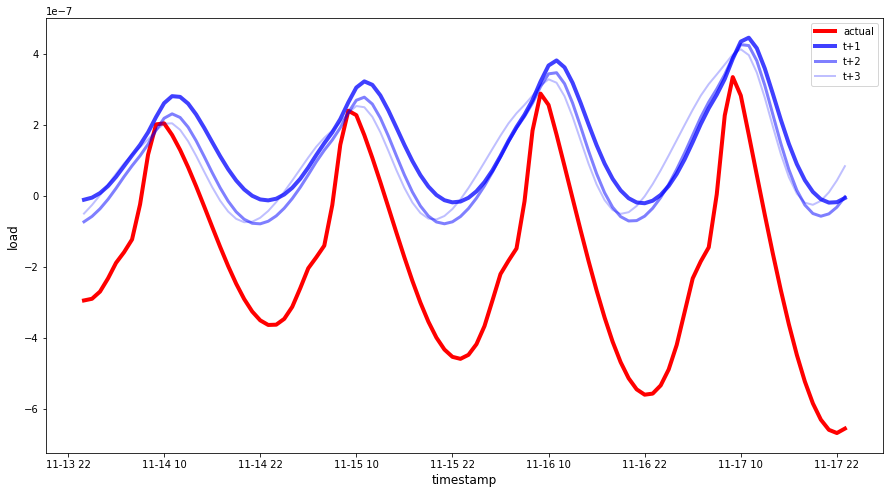

In [123]:
plot_df = eval_df[(eval_df.h=='t+1')][['timestamp', 'actual']]
for t in range(1, HORIZON+1):
    plot_df['t+'+str(t)] = eval_df[ (eval_df.h=='t+'+str(t))]['prediction'].values

fig = plt.figure(figsize=(15, 8))
ax = plt.plot(plot_df['timestamp'], plot_df['actual'], color='red', linewidth=4.0)
ax = fig.add_subplot(111)
ax.plot(plot_df['timestamp'], plot_df['t+1'], color='blue', linewidth=4.0, alpha=0.75)
ax.plot(plot_df['timestamp'], plot_df['t+2'], color='blue', linewidth=3.0, alpha=0.5)
ax.plot(plot_df['timestamp'], plot_df['t+3'], color='blue', linewidth=2.0, alpha=0.25)
plt.xlabel('timestamp', fontsize=12)
plt.ylabel('load', fontsize=12)
ax.legend(loc='best')
plt.show()

# take input here

In [129]:
a = df.iloc[456:480  , :]
Actual = df.iloc[480:504,:]

In [130]:
new_df = pd.DataFrame()

In [131]:
columns = [var_name] 

In [132]:
for key , value in enumerate(columns):
    new_df[value] = a[value]

In [133]:
new_df = new_df.dropna( how = 'any')

In [134]:
new_df

,Cis
Epoch_Time_of_Clock,
2017-11-21 00:00:00,-0.00000085354805271800
2017-11-21 01:00:00,-0.00000078152685197000
2017-11-21 02:00:00,-0.00000067762854129900
2017-11-21 03:00:00,-0.00000054011561785900
2017-11-21 04:00:00,-0.00000036924914759000
2017-11-21 05:00:00,-0.00000021125727851400
2017-11-21 06:00:00,-0.00000015200000000000
2017-11-21 07:00:00,-0.00000013276224463000
2017-11-21 08:00:00,0.00000004076374532070


In [135]:
# creating index for output
import datetime
date = new_df.index.date[0]
date + datetime.timedelta(1)

datetime.date(2017, 11, 22)

In [136]:
import datetime
date = new_df.index + datetime.timedelta(days =1)

In [137]:
date

DatetimeIndex(['2017-11-22 00:00:00', '2017-11-22 01:00:00',
               '2017-11-22 02:00:00', '2017-11-22 03:00:00',
               '2017-11-22 04:00:00', '2017-11-22 05:00:00',
               '2017-11-22 06:00:00', '2017-11-22 07:00:00',
               '2017-11-22 08:00:00', '2017-11-22 09:00:00',
               '2017-11-22 10:00:00', '2017-11-22 11:00:00',
               '2017-11-22 12:00:00', '2017-11-22 13:00:00',
               '2017-11-22 14:00:00', '2017-11-22 15:00:00',
               '2017-11-22 16:00:00', '2017-11-22 17:00:00',
               '2017-11-22 18:00:00', '2017-11-22 19:00:00',
               '2017-11-22 20:00:00', '2017-11-22 21:00:00',
               '2017-11-22 22:00:00', '2017-11-22 23:00:00'],
              dtype='datetime64[ns]', name='Epoch_Time_of_Clock', freq='H')

In [138]:
new_df.index= date

In [139]:
new_df.columns

Index(['Cis'], dtype='object')

In [140]:
print(new_df)
print(new_df.columns)

                                        Cis
Epoch_Time_of_Clock                        
2017-11-22 00:00:00 -0.00000085354805271800
2017-11-22 01:00:00 -0.00000078152685197000
2017-11-22 02:00:00 -0.00000067762854129900
2017-11-22 03:00:00 -0.00000054011561785900
2017-11-22 04:00:00 -0.00000036924914759000
2017-11-22 05:00:00 -0.00000021125727851400
2017-11-22 06:00:00 -0.00000015200000000000
2017-11-22 07:00:00 -0.00000013276224463000
2017-11-22 08:00:00  0.00000004076374532070
2017-11-22 09:00:00  0.00000032417152486000
2017-11-22 10:00:00  0.00000043763591045400
2017-11-22 11:00:00  0.00000031658800052400
2017-11-22 12:00:00  0.00000011883965120500
2017-11-22 13:00:00 -0.00000006932111125250
2017-11-22 14:00:00 -0.00000024300000000000
2017-11-22 15:00:00 -0.00000040064989670200
2017-11-22 16:00:00 -0.00000054100000000000
2017-11-22 17:00:00 -0.00000066262238334400
2017-11-22 18:00:00 -0.00000076408777229100
2017-11-22 19:00:00 -0.00000084400000000000
2017-11-22 20:00:00 -0.000000901

In [141]:
freq = None
idx_tuples = []
drop_incomplete  = True
new_df[[var_name]] = X_scaler.transform(new_df)
new_new_df = new_df.copy()
tensor_structure={'X':(range(-T+1, 1), [var_name])}
for name, structure in tensor_structure.items():
        rng = structure[0]
        dataset_cols = structure[1]
        for col in dataset_cols:
        # do not shift non-sequential 'static' features
            if rng is None:
                new_df['context_'+col] = new_df[col]
                idx_tuples.append((name, col, 'static'))
            else:
                for t in rng:
                    sign = '+' if t > 0 else ''
                    shift = str(t) if t != 0 else ''
                    period = 't'+sign+shift
                    shifted_col = name+'_'+col+'_'+ period
                    new_new_df[shifted_col] = new_new_df[col].shift(t*-1, freq=freq)
                    idx_tuples.append((name, col, period))
        new_new_df = new_new_df.drop(new_df.columns, axis=1)
        idx = pd.MultiIndex.from_tuples(idx_tuples, names=['tensor', 'feature', 'time step'])
        print(new_df.head())
        new_new_df.columns = idx
        if drop_incomplete:
            new_new_df = new_new_df.dropna(how='any')
            
inputs = {}           
for name, structure in tensor_structure.items():
    rng = structure[0]
    cols = structure[1]
    tensor = new_new_df[name][cols].as_matrix()
    if rng is None:
        tensor = tensor.reshape(tensor.shape[0], len(cols))
    else:
        tensor = tensor.reshape(tensor.shape[0], len(cols), len(rng))
        tensor = np.transpose(tensor, axes=[0, 2, 1])
    inputs[name] = tensor

                                        Cis
Epoch_Time_of_Clock                        
2017-11-22 00:00:00 -2.78606922874000062507
2017-11-22 01:00:00 -2.63330926285077770999
2017-11-22 02:00:00 -2.41293661939008785566
2017-11-22 03:00:00 -2.12126598246857156482
2017-11-22 04:00:00 -1.75885108381626009688


In [142]:
print(new_new_df)
print(inputs['X'])

tensor                                    X                          \
feature                                 Cis                           
time step                              t-23                    t-22   
Epoch_Time_of_Clock                                                   
2017-11-22 23:00:00 -2.78606922874000062507 -2.63330926285077770999   

tensor                                                               \
feature                                                               
time step                              t-21                    t-20   
Epoch_Time_of_Clock                                                   
2017-11-22 23:00:00 -2.41293661939008785566 -2.12126598246857156482   

tensor                                                               \
feature                                                               
time step                              t-19                    t-18   
Epoch_Time_of_Clock                                                   
2017

In [143]:
predictions = model.predict(inputs['X'])

In [144]:
predictions

array([[-0.85148996  , -0.70287484  , -0.45797765  , -0.25550228  ,
        -0.10917907  , -0.0154085215,  0.03157843  ,  0.037985392 ,
         0.009358717 , -0.04908394  , -0.12927024  , -0.22817154  ,
        -0.33719137  , -0.45109075  , -0.56649584  , -0.68283576  ,
        -0.8008365   , -0.9201102   , -1.0366158   , -1.1400468   ,
        -1.2139106   , -1.2417078   , -1.2171155   , -1.1495235   ]],
      dtype=float32)

In [145]:
print(predictions.shape)


(1, 24)


In [146]:
results = predictions[-1, :]

In [147]:
results

array([-0.85148996  , -0.70287484  , -0.45797765  , -0.25550228  ,
       -0.10917907  , -0.0154085215,  0.03157843  ,  0.037985392 ,
        0.009358717 , -0.04908394  , -0.12927024  , -0.22817154  ,
       -0.33719137  , -0.45109075  , -0.56649584  , -0.68283576  ,
       -0.8008365   , -0.9201102   , -1.0366158   , -1.1400468   ,
       -1.2139106   , -1.2417078   , -1.2171155   , -1.1495235   ],
      dtype=float32)

In [148]:
res_df = pd.DataFrame(results , columns = [var_name])
res_df

,Cis
0,-0.85148996114730834961
1,-0.70287483930587768555
2,-0.45797765254974365234
3,-0.25550228357315063477
4,-0.10917907208204269409
5,-0.01540852151811122894
6,0.03157842904329299927
7,0.03798539191484451294
8,0.00935871712863445282
9,-0.04908394068479537964


In [149]:
res_df.index = date
res_df

,Cis
Epoch_Time_of_Clock,
2017-11-22 00:00:00,-0.85148996114730834961
2017-11-22 01:00:00,-0.70287483930587768555
2017-11-22 02:00:00,-0.45797765254974365234
2017-11-22 03:00:00,-0.25550228357315063477
2017-11-22 04:00:00,-0.10917907208204269409
2017-11-22 05:00:00,-0.01540852151811122894
2017-11-22 06:00:00,0.03157842904329299927
2017-11-22 07:00:00,0.03798539191484451294
2017-11-22 08:00:00,0.00935871712863445282


In [150]:
res_df[var_name] = y_scalar.inverse_transform(res_df[[var_name]])    

# final generated output 

In [151]:
# final generated ouput
res_df['actual'] = Actual
res_df

,Cis,actual
Epoch_Time_of_Clock,,
2017-11-22 00:00:00,0.00000005854117901549,-0.00000087107963824400
2017-11-22 01:00:00,0.00000012860822096172,-0.00000079216583328300
2017-11-22 02:00:00,0.00000024406904231000,-0.00000068186398433700
2017-11-22 03:00:00,0.00000033952940725612,-0.00000053876919447600
2017-11-22 04:00:00,0.00000040851588778423,-0.00000036359483717600
2017-11-22 05:00:00,0.00000045272554416442,-0.00000020577450522400
2017-11-22 06:00:00,0.00000047487833398918,-0.00000015654352028800
2017-11-22 07:00:00,0.00000047789899326744,-0.00000015013019468600
2017-11-22 08:00:00,0.00000046440246137536,0.00000002675227234720


In [153]:
res_df.to_csv('SA2_Cis.csv')